## Imports

In [1]:
# necessary imports
import random
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Flatten
# from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
# from keras.optimizers import SGD
from tensorflow.keras import datasets, models #gpu
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, Dropout, Flatten
# import # macro f1 score - https://bestkcs1234.tistory.com/61

# import albumentations as A
# https://albumentations.ai/docs/examples/tensorflow-example/
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# tf.enable_v2_behavior()

In [3]:
# tf.config.experimental.list_physical_devices('GPU')

In [4]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Hyperparameter Setting

In [5]:
CFG = {
    'FPS' : 30,
    'IMG_SIZE': 128,
    'EPOCHS': 10,
    'LEARNING_RATE': 3e-4,
    'BATCH_SIZE': 4,
    'SEED': 41
}

## Fixed RandomSeed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # SEED 고정
    

## Data Load

In [7]:
train = pd.read_csv('./data/train.csv')

In [8]:
train.head()

id                   path  label
0  TRAIN_000  ./train/TRAIN_000.mp4      3
1  TRAIN_001  ./train/TRAIN_001.mp4      0
2  TRAIN_002  ./train/TRAIN_002.mp4      1
3  TRAIN_003  ./train/TRAIN_003.mp4      4
4  TRAIN_004  ./train/TRAIN_004.mp4      4

In [9]:
train['label'].value_counts()

3    133
1    129
2    121
4    114
0    113
Name: label, dtype: int64

### train 데이터 label 분포

In [10]:
train['label'].value_counts().values

array([133, 129, 121, 114, 113])

([<matplotlib.patches.Wedge at 0x2c8a17430>,
 [Text(0.8518816777434608, 0.6959149424498562, '3'),
  Text(-0.49180322740623394, 0.9839357628995972, '1'),
  Text(-1.0821777337152425, -0.1972089061146626, '2'),
  Text(-0.1972087541334739, -1.082177761411277, '4'),
  Text(0.9189213344776592, -0.6046350808891245, '0')],
 [Text(0.46466273331461494, 0.3795899686090124, '21.8%'),
  Text(-0.26825630585794574, 0.5366922343088711, '21.1%'),
  Text(-0.5902787638446777, -0.10756849424436142, '19.8%'),
  Text(-0.10756841134553122, -0.5902787789516056, '18.7%'),
  Text(0.5012298188059958, -0.3298009532122497, '18.5%')])

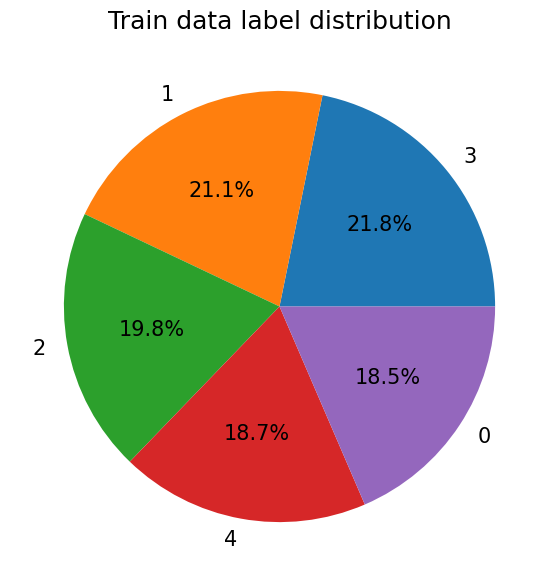

In [11]:
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['3', '1', '2', '4', '0'] # 타깃값 레이블
plt.title('Train data label distribution')
plt.pie(train['label'].value_counts().values, labels=label, autopct='%.1f%%')


In [12]:
test = pd.read_csv('./data/test.csv')

In [13]:
test.head()

id                 path
0  TEST_000  ./test/TEST_000.mp4
1  TEST_001  ./test/TEST_001.mp4
2  TEST_002  ./test/TEST_002.mp4
3  TEST_003  ./test/TEST_003.mp4
4  TEST_004  ./test/TEST_004.mp4

## Train/ Validation Split

In [14]:
_, val, _, _ = train_test_split(train, train['label'], test_size=0.2, stratify=train['label'], random_state=CFG['SEED'])

In [15]:
val.shape

(122, 3)

## CustomDataset

In [ ]:
train.head()

In [ ]:
file_path = './data/train/' + train.loc[0]['id'] + '.mp4'
file_path

In [ ]:
import matplotlib.gridspec as gridspec

mpl.rc('font', size=8)
plt.figure(figsize=(15,  8))
grid = gridspec.GridSpec(3, 10)

# 1초에 30프레임

frames = []
cap = cv2.VideoCapture(file_path) # 영상 불러오기 30프레임 리턴됨.
for i in range(CFG['FPS']): # 프레임 단위로 짤라서 반복문안에서 처리
    _, img = cap.read()# 30프레임중에 한개씩
    ax = plt.subplot(grid[i])
    ax.imshow(img)
    img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE'])) # img 리사이징
    img = img / 255. # 픽셀값 정규화 RGB 별로 각각 0~255 사이의 값을 가지는 픽셀값의 array들을 0~1 사이값으로 정규화
    frames.append(img)

In [ ]:
frames[1].shape

In [ ]:
np.array(frames).shape

In [ ]:
train.head()

In [ ]:
val.reset_index(inplace=True)
val.drop('index', axis=1, inplace=True)
val.head()

In [ ]:
frames_train = []
# train_label = []
frames_val = []
# val_label = []

for i in tqdm(range(len(train))):
    tmp = []
    file_name = train.loc[i,'id']
    # label = train.loc[i, 'label']
    file_path = f'./data/train/{file_name}.mp4'
    cap = cv2.VideoCapture(file_path)
    for _ in range(CFG['FPS']):
        _, img = cap.read()
        img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
        img = img / 255.
        tmp.append(img)
        # train_label.append(label)
    frames_train.append(tmp)


for i in tqdm(range(len(val))):
    tmp = []
    file_name = val.loc[i, 'id']
    # label = val.loc[i, 'label']
    file_path = f'./data/train/{file_name}.mp4'
    cap = cv2.VideoCapture(file_path)
    for _ in range(CFG['FPS']):
        _, img = cap.read()
        img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
        img = img / 255.
        tmp.append(img)
        # val_label.append(label)
    frames_val.append(tmp)

In [ ]:
np.array(frames_train).shape, np.array(frames_val).shape

In [ ]:
# train, val set
frames_train = np.array(frames_train)
frames_val = np.array(frames_val)
train_label = train['label'].values
val_label = val['label'].values

In [ ]:
val_label

In [ ]:
frames_train.dtype

In [ ]:
frames_train = frames_train.astype('float32')
frames_train.dtype

In [ ]:
frames_val = frames_val.astype('float32')

In [ ]:
train_label.dtype

In [ ]:
val['label'].values

## Model Define

In [ ]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(5))
input_shape=(30, 128, 128, 3)

model = models.Sequential()
model.add(Conv3D(8, (3, 3, 3), activation='relu', padding='same', name='conv1', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2, strides=(1, 1, 1), padding='valid', name='pool1'))
# 2nd layer group
model.add(Conv3D(32, (2, 2, 2), activation='relu', padding='same', name='conv2', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2, strides=(1, 1, 1), padding='valid', name='pool2'))
# 3rd layer group
model.add(Conv3D(64, (2, 2, 2), activation='relu', padding='same', name='conv3', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2, strides=(1, 1, 1), padding='valid', name='pool3'))
# 4th layer group
model.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same', name='conv4', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(1, 7, 7), strides=(1, 1, 1), padding='valid', name='pool4'))
# # 5th layer group
# model.add(Convolution3D(256, (3, 3, 3), activation='relu', padding='same', name='conv5', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='valid', name='pool5'))
model.add(Flatten())
# FC layers group
model.add(Dense(512, activation='relu', name='fc6'))
model.add(Dropout(.5))
# model.add(Dense(2048, activation='relu', name='fc7'))
# model.add(Dropout(.5))
model.add(Dense(5, activation='softmax', name='fc8'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(frames_train, train_label, epochs=10, batch_size=4, validation_data=(frames_val, val_label))


In [ ]:
test.head()

In [ ]:
frames_test = []

file_path = f'./data/test/TEST_000.mp4'
cap = cv2.VideoCapture(file_path)
for _ in range(CFG['FPS']):
    _, img = cap.read()
    img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
    img = img / 255.
    frames_test.append(img)

In [ ]:
pred = model.predict(np.array(frames_test))

In [ ]:
pred